# Network characterization

The integrated network contains information derived from multiple resources. We first study the content of the network.

## Resources and Likelihood ratio Distributions

In [1]:
%matplotlib inline
import os 
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from collections import defaultdict, Counter
from operator import itemgetter
from IPython.display import Image, display
import networkx as nx
from src import misc, ora
import powerlaw
import multiprocessing

project_directory = '/projects/ooihs/ReNet'
final_directory = os.path.join(project_directory, 'results/final')
network_file = os.path.join(final_directory, 'integrated.network.uniprot')

data_directory = os.path.join(project_directory, 'data')
hgnc_file = os.path.join(data_directory, 'hgnc/hgnc_complete_set.json')
hgnc = misc.load_hgnc_json(hgnc_file)

In [2]:
resources = []
lratios = []
network = nx.Graph()

with open(network_file) as ifh:
    for line in ifh:
        col = line.strip().split('\t')
        network.add_edge(col[0], col[1])
        info = json.loads(col[2])
        lratios.append(info['lr'])
        resources.append(len(info['supports'].keys()))

### Number of interactions observed in various resources

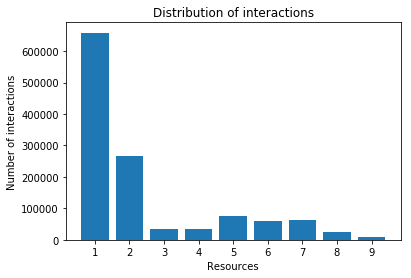

In [3]:
dist = Counter(resources)
distx = sorted(dist.keys())
disty = [dist[x] for x in distx]

fig, ax = plt.subplots()
ax.bar(distx, disty)
ax.set_ylabel('Number of interactions')
ax.set_xlabel('Resources')
ax.set_xticks(distx)
ax.set_xticklabels(distx)
plt.title('Distribution of interactions')
plt.show()

### Distribution of likelihood ratios

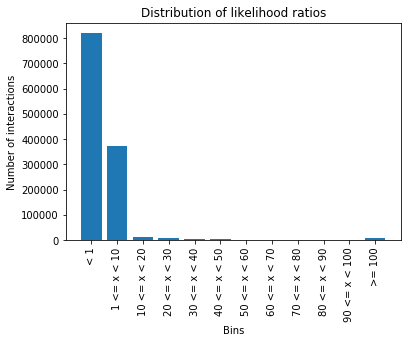

In [4]:
def bins(value):
    """convert a value into the corresponding bin"""
    labels = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    for i, j in enumerate(labels):
        if value < j:
            return i
    return len(labels)

def labels(index):
    """create a label for a particular bin"""
    labels = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    if index == 0:
        return '< 1'
    elif index == len(labels):
        return '>= 100'
    else:
        return '{} <= x < {}'.format(labels[index-1], labels[index])

dist = Counter([bins(lr) for lr in lratios])
disty = [dist[x] for x in range(12)]
fig, ax = plt.subplots()
ax.bar(range(12), disty)
ax.set_ylabel('Number of interactions')
ax.set_xlabel('Bins')
ax.set_xticks(range(12))
ax.set_xticklabels([labels(i) for i in range(12)], rotation=90)
plt.title('Distribution of likelihood ratios')
plt.show()

In [5]:
# convert the list of likelihood ratios into a numpy array for 
# fast processing
lr = np.array(lratios)

print('Total number of interactions:', lr.size)
print('Number of interactions with lr >= 1.0:', (lr >= 1).sum())
print('Number of interactions with lr >= 100.0:', (lr >= 100).sum())

Total number of interactions: 1231170
Number of interactions with lr >= 1.0: 411188
Number of interactions with lr >= 100.0: 7038


## Network characteristics

For each network, we calculated the number of interactions, proteins and connected components. Generally, all the proteins in an organism should be connected to each other to form a large network. Unconnected proteins should that a dataset is still incomplete. 

We also fitted the degree distribution of each network to power-law distribution. It has been proposed that the protein-protein interaction networks are an example of scale-free networks. The degree distribution of a scale-free network follows a power law $P(k) \approx k^{-\alpha}$. The main characteristics of a scale-free network are generally a few well-connected nodes and a lot of poorly connected nodes.

The following is an example of power-law graph and its corresponding figure in log-log scale.

![figure](powerlaw_fig.png)


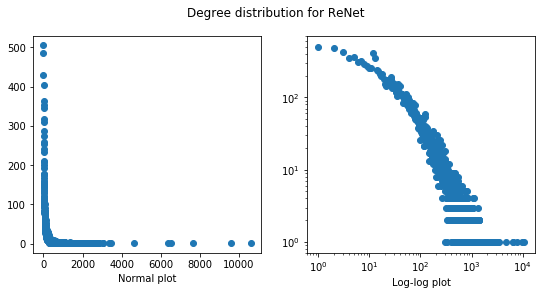

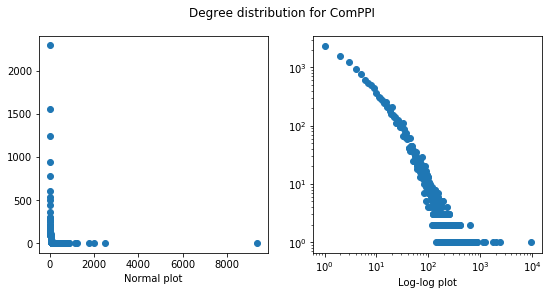

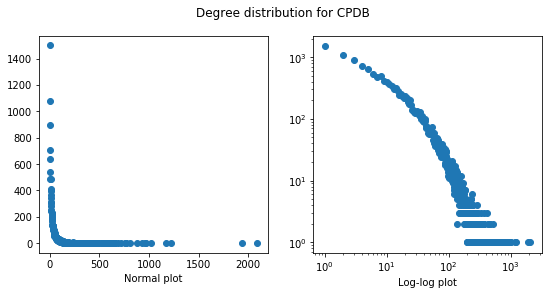

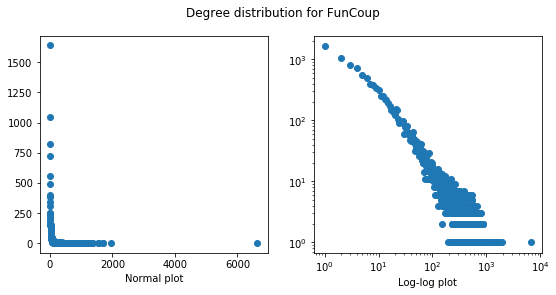

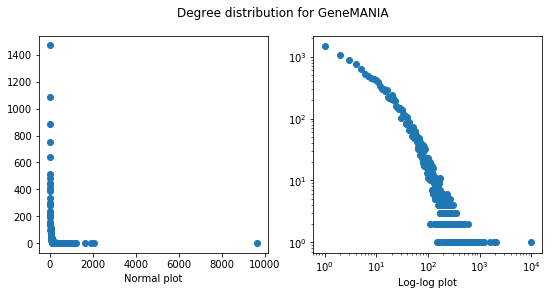

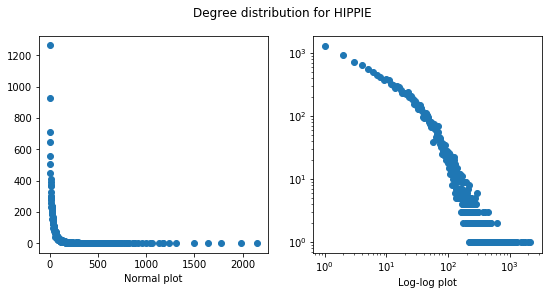

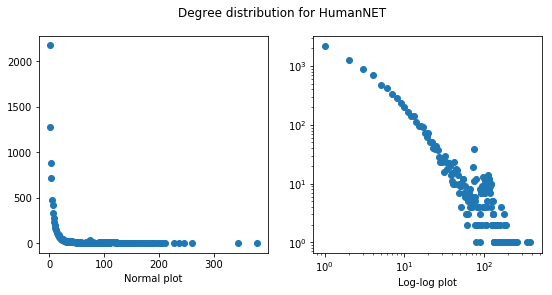

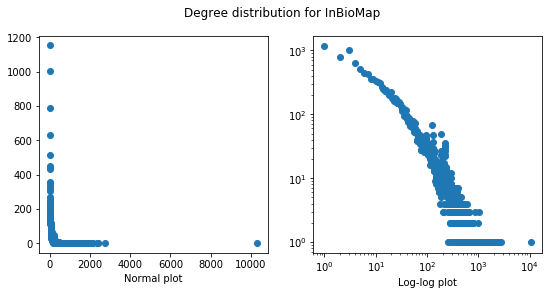

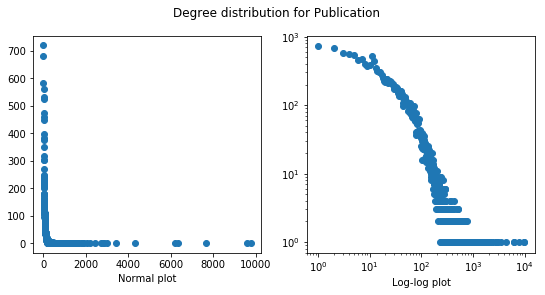

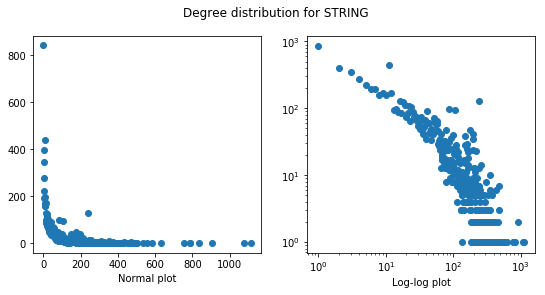

In [6]:
def plot_degree_distribution(network, dataset):    
    degree_dist = Counter(dict(nx.degree(network)).values())

    x = sorted(degree_dist.keys(), reverse=True)
    y = [degree_dist[k] for k in x]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,4))

    fig.suptitle('Degree distribution for ' + dataset)
    p1 = ax[0].scatter(x,y)
    ax[0].set_xlabel('Normal plot')
    
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Log-log plot')
    p2 = ax[1].scatter(x,y)

    plt.show()
    
datasets = ['ReNet', 'ComPPI', 'CPDB', 'FunCoup', 'GeneMANIA', 'HIPPIE', 'HumanNET',
           'InBioMap', 'Publication', 'STRING']

# the number of protein-coding genes
protein_size = len(hgnc['uniprot'])

job_list = []
for ds in datasets:
    network_file = ''
    if ds == 'ReNet':
        network_file = os.path.join(final_directory, 'integrated.network.uniprot')
    else:
        network_file = os.path.join(final_directory, 'score.' + ds.lower())
        
    net = nx.Graph()
    
    with open(network_file) as ifh:
        for line in ifh:
            col = line.strip().split('\t')
            net.add_edge(col[0], col[1])

    plot_degree_distribution(net, ds)
        
    job_list.append((ds, network_file))

## Degree distribution for a sample network based on Barabasi-Albert model


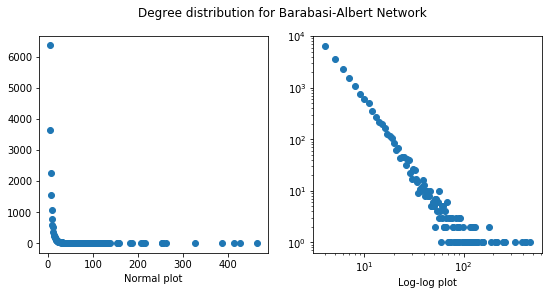

In [7]:
ba_network = nx.barabasi_albert_graph(network.number_of_nodes(), 4)
plot_degree_distribution(ba_network, "Barabasi-Albert Network")

## Other statistics

In [8]:
def check_network(args):    
    ds, network_file = args
        
    net = nx.Graph()
    
    with open(network_file) as ifh:
        for line in ifh:
            col = line.strip().split('\t')
            net.add_edge(col[0], col[1])
    
    # fit the raw degrees to powerlaw distribution
    fit = powerlaw.Fit(list(dict(nx.degree(net)).values()), verbose=False)    
    table = {}
    table['Dataset'] = ds
    table['Interaction'] = net.number_of_edges()
    table['Protein'] = net.number_of_nodes()
    table['Connected components'] = nx.number_connected_components(net)
    table['Powerlaw degree'] = fit.alpha
    if table['Connected components'] == 1:
        table['Diameter'] = nx.diameter(net)
        table['Radius'] = nx.radius(net)
        table['Density'] = nx.density(net)
    else:
        # operate on the largest component
        # get the largest component as a subgraph
        subnet = max(nx.connected_component_subgraphs(net), key=len)
        
        table['Diameter'] = nx.diameter(subnet)
        table['Radius'] = nx.radius(subnet)
        table['Density'] = nx.density(subnet)
    
    return table

def run_check(number_of_workers, process_list):
    pool = multiprocessing.Pool(number_of_workers)
    info = pool.imap_unordered(check_network, process_list)

    pool.close()
    pool.join()
    
    columns = ['Interaction', 
           'Protein', 
           'Protein coverage', 
           'Connected components', 
           'Diameter',
           'Radius',
           'Density',
           'Powerlaw degree']
    
    datasets = ['ReNet', 'ComPPI', 'CPDB', 'FunCoup', 'GeneMANIA', 'HIPPIE', 'HumanNET',
           'InBioMap', 'Publication', 'STRING']
    
    table = pd.DataFrame(0, index=datasets, columns=columns)
    for item in info:
        ds = item['Dataset']
        for c in columns:
            if c == 'Protein coverage':
                table.loc[ds, c] = item['Protein'] / protein_size
            else:
                table.loc[ds, c] = item[c]
    
    return table

result = run_check(len(datasets), job_list)

/opt/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/opt/anaconda3/lib/python3.6/site-

In [9]:
result

,Interaction,Protein,Protein coverage,Connected components,Diameter,Radius,Density,Powerlaw degree
ReNet,1231170,19185,0.957813,1,7,4,0.006690,3.708817
ComPPI,174813,15534,0.775537,20,9,5,0.001457,2.983370
CPDB,261353,16209,0.809236,12,8,5,0.001996,3.569972
FunCoup,455905,14056,0.701747,52,10,5,0.004699,5.161867
GeneMANIA,259315,16005,0.799051,6,8,4,0.002028,3.196961
HIPPIE,320225,16700,0.833749,8,8,5,0.002301,3.341326
HumanNET,59913,9335,0.466051,91,15,8,0.001435,1.991503
InBioMap,615121,17517,0.874538,4,8,4,0.004013,3.689192
Publication,512190,18890,0.943085,1,7,4,0.002871,2.702974
STRING,257917,9390,0.468797,100,12,6,0.006197,4.891708
